## 수정 내역:
- 최종 라우팅 결과 시각화 (실선 ver.)
---
---

## [0] Import

In [1]:
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import random
import numpy as np

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## [1] Hyperparameters

In [2]:
#Hyperparameters
learning_rate = 0.0001
gamma         = 0.98
n_rollout     = 128
entropy_beta = 0.1

## [2] Pin, Obstacle Generation

Pairs: [((1, 9), (11, 7)), ((2, 2), (10, 0)), ((7, 12), (14, 1))]
Obstacles: [(4, 10), (4, 11), (5, 10), (5, 11), (9, 2), (9, 3), (10, 2), (10, 3)]


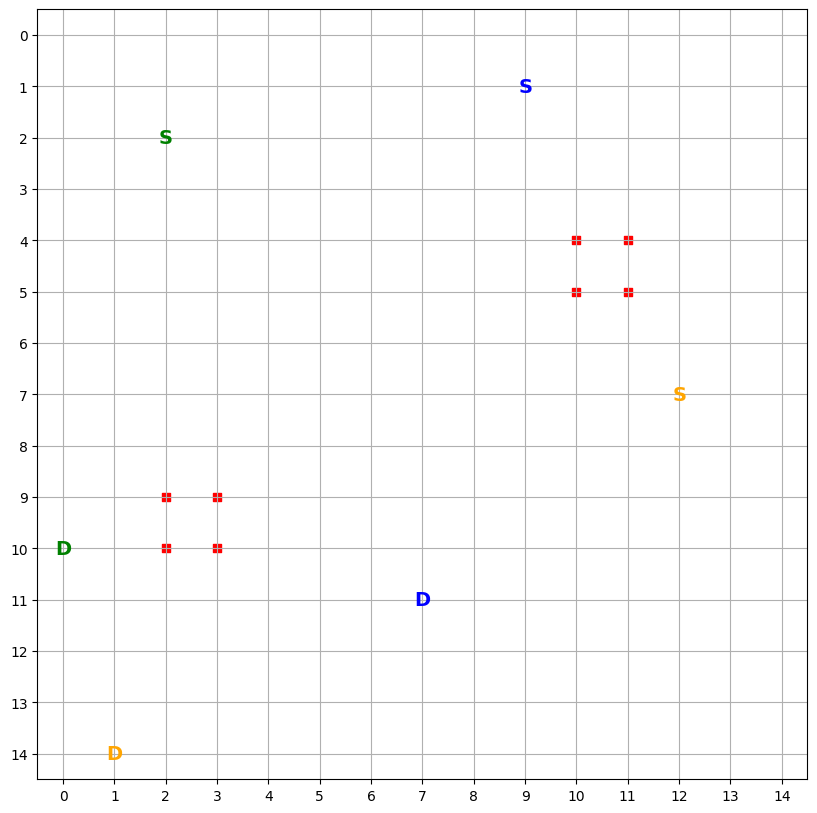

In [33]:
# Environment configuration
GRID_WIDTH = 15
GRID_HEIGHT = 15
GRID_SIZE = (GRID_WIDTH, GRID_HEIGHT)
ACTIONS = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # Right, Left, Down, Up
# [(Start point, Endpoint), (Start point 2, Endpoint 2), ... ]
global PAIRS
global OBSTACLES
# PAIRS = []
# OBSTACLES = []
PAIRS = [((1, 9), (11, 7)), ((2, 2), (10, 0)), ((7, 12), (14, 1))]
OBSTACLES = [(4, 10), (4, 11), (5, 10), (5, 11), (9, 2), (9, 3), (10, 2), (10, 3)]

grid = np.zeros(GRID_SIZE, dtype=int)

def generate_obstacles(grid,obstacles):
    chip_positions = set()

    # # 7x7 칩 2개 생성
    # for _ in range(2):
    #     x, y = random.randint(0, GRID_WIDTH - 7), random.randint(0, GRID_HEIGHT - 7)
    #     while any((x + i, y + j) in chip_positions or grid[x + i][y + j] == 1 for i in range(7) for j in range(7)):
    #         x, y = random.randint(0, GRID_WIDTH - 7), random.randint(0, GRID_HEIGHT - 7)
    #     for i in range(7):
    #         for j in range(7):
    #             chip_positions.add((x + i, y + j))
    #             grid[x + i][y + j] = 1
    #             obstacles.append((x+i,y+j))


    # 2x2 칩 2개 생성
    for _ in range(2):
        x, y = random.randint(0, GRID_WIDTH - 2), random.randint(0, GRID_HEIGHT - 2)
        while any((x + i, y + j) in chip_positions or grid[x + i][y + j] == 1 for i in range(2) for j in range(2)):
            x, y = random.randint(0, GRID_WIDTH - 2), random.randint(0, GRID_HEIGHT - 2)
        for i in range(2):
            for j in range(2):
                chip_positions.add((x + i, y + j))
                grid[x + i][y + j] = 1
                obstacles.append((x+i,y+j))

    # # 1/100 확률로 scatter object 생성
    # for _ in range(100):
    #     x, y = random.randint(0, GRID_WIDTH - 1), random.randint(0, GRID_HEIGHT - 1)
    #     if random.random() < 1/60 and (x, y) not in chip_positions:
    #         grid[x][y] = 1
    #         obstacles.append((x,y))

def generate_pairs(grid, pairs):
    for i in range(3):
        # 랜덤 시작 지점 생성
        start = (random.randint(0, GRID_HEIGHT - 1), random.randint(0, GRID_WIDTH - 1))

        # 랜덤 종료 지점 생성
        end = (random.randint(0, GRID_HEIGHT - 1), random.randint(0, GRID_WIDTH - 1))

        # 시작점과 종료점이 겹치지 않도록 확인
        while start == end or (start, end) in pairs or grid[start[0]][start[1]] == 1 or grid[end[0]][end[1]] == 1:
            start = (random.randint(0, GRID_HEIGHT - 1), random.randint(0, GRID_WIDTH - 1))
            end = (random.randint(0, GRID_HEIGHT - 1), random.randint(0, GRID_WIDTH - 1))

        # 시작점과 종료점 쌍을 리스트에 추가
        pairs.append((start, end))

def plot_grid(grid, pairs, obstacles):
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='Greys', alpha=0.3)

    # Different colors for each pair
    colors = ['blue', 'green', 'orange']

    for idx, (start, end) in enumerate(pairs):
        # Start point with label 'S'
        plt.text(start[1], start[0], 'S', color=colors[idx], ha='center', va='center', fontsize=14, weight='bold')
        # End point with label 'D'
        plt.text(end[1], end[0], 'D', color=colors[idx], ha='center', va='center', fontsize=14, weight='bold')


    #Uncomment below to plot obstacles
    for x, y in obstacles:
        plt.scatter(y, x, color='red', marker='s')  # Swapping x and y for correct plotting

    plt.grid(True)
    plt.xticks(range(GRID_WIDTH))
    plt.yticks(range(GRID_HEIGHT))
    plt.show()

# generate_obstacles(grid,OBSTACLES)
# generate_pairs(grid, PAIRS)
print('Pairs:',PAIRS)
print('Obstacles:',OBSTACLES)
plot_grid(grid, PAIRS, OBSTACLES)

## [3] Environment Configuration

In [26]:
# Environment class
class RoutingEnv:
    # Envirionment 초기화
    # 시작위치 = start point
    # GRID = (GRID_HEIGHT*GRID_WIDTH) size with 0
    def __init__(self, grid, start, destination):
        self.grid = grid
        self.start = start
        self.destination = destination
        global PAIRS
        global OBSTACLES
        self.pairs = PAIRS
        self.obstacles = OBSTACLES

        # Start point, End point 1로 초기화, 나머지는 0
        self.init_pairs(self.grid, self.pairs)


    # pair에 있는 모든 지점을 grid에서 1로 표시(obstacle 취급)
    def init_pairs(self, grid, pairs):
        for i in range(len(pairs)):
          grid[pairs[i][0][0]][pairs[i][0][1]]= 1
          grid[pairs[i][1][0]][pairs[i][1][1]]= 1

    # obstacle이 위치한 모든 지점을 grid에서 1로 표시
    def init_obstacles(self, grid, obstacles):
        for i in range(len(obstacles)):
          grid[obstacles[i][0]][obstacles[i][1]]= 1

    # 시작위치로 초기화
    # Grid 모두 0으로 초기화
    # pair에 있는 모든 지점을 grid에서 1로 표시(obstacle 취급)
    # self.start, self.destination 각각 1, 2로 대입
    # obstacle도 1로 표시
    def reset(self, solutions):
        self.current_position = self.start
        if len(solutions) == 0:
          self.grid = np.zeros(GRID_SIZE, dtype=int)
        else:
          grid = copy.deepcopy(solutions[-1])
          self.grid = np.zeros(GRID_SIZE, dtype=int)
          self.grid = grid

        self.init_pairs(self.grid, self.pairs)
        self.init_obstacles(self.grid, self.obstacles)

        self.grid[self.destination[0]][self.destination[1]] = 2

        return self.get_state()

    # 현재 Grid state와 Agent의 position을 담은 Grid를 concat (160차원 벡터)하여 반환
    def get_state(self):
        flat_grid = self.grid.flatten()
        pos = np.zeros(GRID_SIZE, dtype=int)
        pos[self.current_position[0]][self.current_position[1]] = 1
        flat_pos = pos.flatten()
        state = np.concatenate((flat_grid, flat_pos))
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        return state

    # Agent 움직임
    # Return : next state, reward, done
    def step(self, action, solutions):
        dx, dy = ACTIONS[action]
        old_position = (self.current_position[0], self.current_position[1])
        new_position = (self.current_position[0] + dx, self.current_position[1] + dy)

        # 목적지 도착 확인
        if self.current_position == self.destination:
            return self.get_state(), torch.tensor([1000]), True, self.current_position
        else:
            # Move to the new position
            self.grid[self.current_position[0]][self.current_position[1]] = 1  # Mark old position as visited
            self.current_position = new_position
            # self.grid[new_position[0]][new_position[1]] = 1  # Mark new position as visited

        # # Agent가 Grid 밖으로 탈출할 경우
        # if (new_position[0] < 0 or new_position[0] >= GRID_SIZE[0] or
        #     new_position[1] < 0 or new_position[1] >= GRID_SIZE[1]):

        #     self.current_position = old_position
        #     self.grid[self.current_position[0]][self.current_position[1]] = 1
        #     # self.grid[new_position[0]][new_position[1]] = 0

        # # 이미 방문한 곳인지 파악 (wire 교차 Check)
        # elif self.grid[new_position[0]][new_position[1]] == 1:
        #     self.current_position = old_position
        #     self.grid[self.current_position[0]][self.current_position[1]] = 1
        #     # self.grid[new_position[0]][new_position[1]] = 0

        # else : self.grid[self.current_position[0]][self.current_position[1]] = 1

        # return self.get_state(), torch.tensor([-1]), False, self.current_position

        # Agent가 Grid 밖으로 탈출할 경우
        if (new_position[0] < 0 or new_position[0] >= GRID_SIZE[0] or
            new_position[1] < 0 or new_position[1] >= GRID_SIZE[1]):


            self.reset(solutions)
            # print("Out of Bound")

            return self.get_state(), torch.tensor([-1]), False, self.current_position  # Out of bounds

        # 이미 방문한 곳인지 파악 (wire 교차 Check)
        if self.grid[new_position[0]][new_position[1]] == 1:
            self.reset(solutions) # 자신의 Routing 경로에 아예 갇혀서 안움직이는 경우 Reset

            # return self.get_state(), -80, True
            return self.get_state(), torch.tensor([-1]), False, self.current_position  # Already visited

        # Move to the new position
        self.grid[self.current_position[0]][self.current_position[1]] = 1  # Mark old position as visited
        self.current_position = new_position
        self.grid[new_position[0]][new_position[1]] = 1  # Mark new position as visited

        # 목적지 도착 확인
        if self.current_position == self.destination:
            return self.get_state(), torch.tensor([100]), True, self.current_position

        return self.get_state(), torch.tensor([-1]), False, self.current_position

    def render(self):
        print('-' * 50)
        for i in range(GRID_SIZE[1]):
            for j in range(GRID_SIZE[0]):
                if (i, j) == self.start:
                    print('S', end=' ')
                elif (i, j) == self.destination:
                    print('D', end=' ')
                elif (i, j) == self.current_position:
                    print('A', end=' ')
                elif self.grid[i][j] == 1:
                    print('*', end=' ')
                else:
                    print('.', end=' ')
            print()  # New line for next row
        print('-'*50)

## [4] Actor Critic Algorithm

In [27]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.data = []

        # self.fc1 = nn.Linear(GRID_WIDTH * GRID_HEIGHT * 2, 128)
        self.fc1 = nn.Linear(GRID_WIDTH * GRID_HEIGHT * 2, 128)
        self.fc2 = nn.Linear(GRID_WIDTH * GRID_HEIGHT * 2, 128)
        # self.bn1 = nn.BatchNorm1d(128)
        self.fc_pi_1 = nn.Linear(128, 64)
        # self.bn_pi_1 = nn.BatchNorm1d(64)
        self.fc_v_1 = nn.Linear(128,64)
        # self.bn_v_1 = nn.BatchNorm1d(64)
        self.fc_pi = nn.Linear(64,4)
        self.fc_v = nn.Linear(64,1)
        # self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.pi_optimizer = optim.Adam([{'params': self.fc1.parameters()},
                                        {'params': self.fc_pi_1.parameters()},
                                        {'params': self.fc_pi.parameters()}], lr=learning_rate)

        self.v_optimizer = optim.Adam([{'params': self.fc2.parameters()},
                                       {'params': self.fc_v_1.parameters()},
                                       {'params': self.fc_v.parameters()}], lr=learning_rate)

        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')

        nn.init.kaiming_normal_(self.fc_pi.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc_v.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc_pi_1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc_v_1.weight, nonlinearity='relu')

    # 정책 계산
    def pi(self, x, softmax_dim=0):
        x = self.fc1(x)
        # if x.size(0) > 1:
        #     x = self.bn1(x)
        x = F.relu(x)
        x = self.fc_pi_1(x)
        # if x.size(0) > 1:
        #     x = self.bn_pi_1(x)
        x = F.relu(x)
        x = self.fc_pi(x)
        # print(f"정책 함수의 x : {x.size()}")
        prob = F.softmax(x) #, dim=1)# , dim=softmax_dim)
        return prob

    # 가치 계산
    def v(self, x):
        x = self.fc2(x)
        # if x.size(0) > 1:
        #     x = self.bn1(x)
        x = F.relu(x)
        x = self.fc_v_1(x)
        # if x.size(0) > 1:
        #     x = self.bn_v_1(x)
        x = F.relu(x)
        v = self.fc_v(x)
        return v

    def put_data(self, transition):
        self.data.append(transition)

    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, done_lst = [], [], [], [], []
        for transition in self.data:
            s,a,r,s_prime,done = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r/100])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0
            done_lst.append([done_mask])

        s_batch, a_batch, r_batch, s_prime_batch, done_batch = torch.stack(s_lst).squeeze().to(device), torch.tensor(a_lst).to(device), \
                                                               torch.tensor(r_lst, dtype=torch.float).to(device), torch.stack(s_prime_lst).squeeze().to(device), \
                                                               torch.tensor(done_lst, dtype=torch.float).to(device)
        self.data = []
        return s_batch, a_batch, r_batch, s_prime_batch, done_batch

    def train_net(self):
        s, a, r, s_prime, done = self.make_batch()
        td_target = r + gamma * self.v(s_prime) * done
        delta = td_target - self.v(s)

        pi = self.pi(s, softmax_dim=-1)
        if len(pi.size()) == 1 : pi = pi[None, :]
        pi_a = pi.gather(-1,a)
        policy_loss = -torch.log(pi_a) * delta.detach()
        critic_loss = F.smooth_l1_loss(self.v(s), td_target.detach())
        # critic_loss = critic_loss.unsqueeze(0)  # Now has shape [1]
        # critic_loss = critic_loss.expand_as(policy_loss)  # Now has shape [64, 1] like policy loss
        # print(f"policy loss : {policy_loss.size()}, value: {policy_loss}")
        # print(f"critic loss : {critic_loss.size()}, value: {critic_loss}")
        # loss = policy_loss+critic_loss
        # self.optimizer.zero_grad()

        self.pi_optimizer.zero_grad()
        self.v_optimizer.zero_grad()
        policy_loss.mean().backward()
        critic_loss.backward()
        self.pi_optimizer.step()
        self.v_optimizer.step()

        # Q function 값 리턴
        return self.v(s), policy_loss.mean()

        # loss.mean().backward()
        # self.optimizer.step()

## [5] Routing Result Visualization

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_routing(positions,pairs,obstacles):
    plt.figure(figsize=(8, 8))



    # 장애물 표시
    # for obs in OBSTACLES:
    #         # # Adjust coordinates to create a half-grid-size box
    #         # obs_x = obs[1] - 0.5
    #         # obs_y = GRID_SIZE[0] - 1 - obs[0] - 0.5
    #         # plt.gca().add_patch(plt.Rectangle((obs_x, obs_y), 1, 1, color='grey', zorder =3 ))
    #         for x, y in obs:
    #           plt.scatter(y, x, color='red', marker='s')  # Swapping x and y for correct plotting

    #print(positions)
    # positions 리스트의 좌표를 해당 색상으로 시각화
    colors = ['blue', 'red', 'orange']
    for idx, pos_list in enumerate(positions):
        for i in range(len(pos_list)-1):
            x1, y1 = pos_list[i]
            x2, y2 = pos_list[i + 1]
            plt.plot([x1, x2], [y1, y2], color=colors[idx], marker='.', zorder=3)
    plt.plot([pairs[0][0][0], positions[0][0][0]], [pairs[0][0][1], positions[0][0][1]], color=colors[0], marker='.', zorder=3)
    plt.plot([pairs[1][0][0], positions[1][0][0]], [pairs[1][0][1], positions[1][0][1]], color=colors[1], marker='.', zorder=3)
    plt.plot([pairs[2][0][0], positions[2][0][0]], [pairs[2][0][1], positions[2][0][1]], color=colors[2], marker='.', zorder=3)


    for idx, pair_list in enumerate(pairs):
        for pair in pair_list:
            x,y = pair
            plt.scatter(x, y, color = colors[idx], marker = 'P',zorder=3)




    plt.title('Routing Paths for Pin Pairs')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.xticks(range(GRID_WIDTH))
    plt.yticks(range(GRID_HEIGHT))
    plt.grid(True)
    plt.show()

## [6] Save Movel

In [29]:
import os

def save_model_info(model,reward_list, step_list, model_name="ver_1"):

    os.makedirs('./models', exist_ok = True)

    # 모델 정보 저장
    torch.save({'model_state_dict': model.state_dict(),
                'rewards': reward_list,
                'steps': step_list
                }, f"./models/model_{model_name}.pth")
    print(f"model_saved : model_{model_name}")

## [7] Training

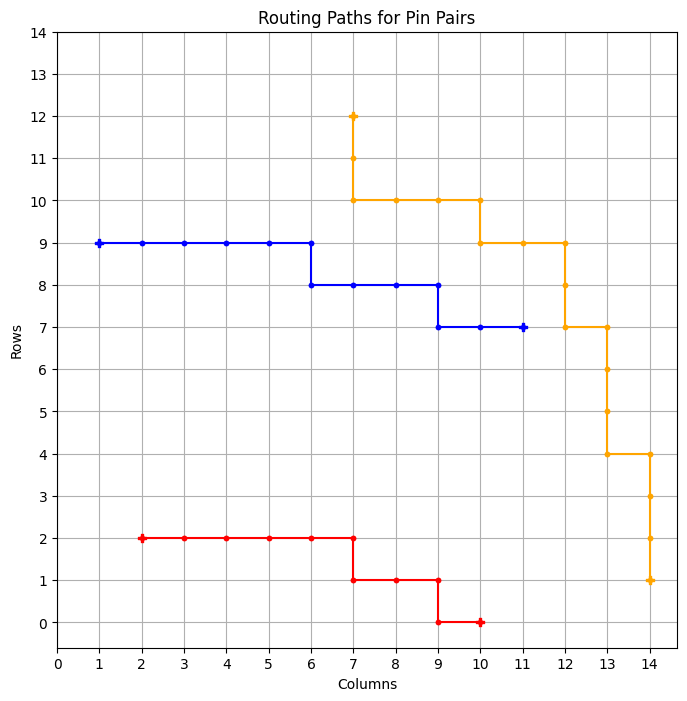

============ BEST GRID ==============
Episode: 1713 	 Total Rewards: tensor([263]) 	 Average Steps: 138.57 	 Elapsed Time: 1002.90
--------------------------------------------------
. . . . . . . . . . . . . . . 
. . . . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * * * . . . 
. . * . . . . . . * * * . . . 
. . * . . . . . * * . . . . . 
. * * . . . . . * . * * S . . 
. * . . . . . . * . * . . . . 
* * * * . . . * * . * . . . . 
* . * * . . . * . * * . . . . 
. . . . . . . * . * . . . . . 
. . . . . . . * * * . . . . . 
. . . . * * * * . . . . . . . 
. D * * * . . . . . . . . . . 
--------------------------------------------------
model_saved : model_best_750
tensor([263])


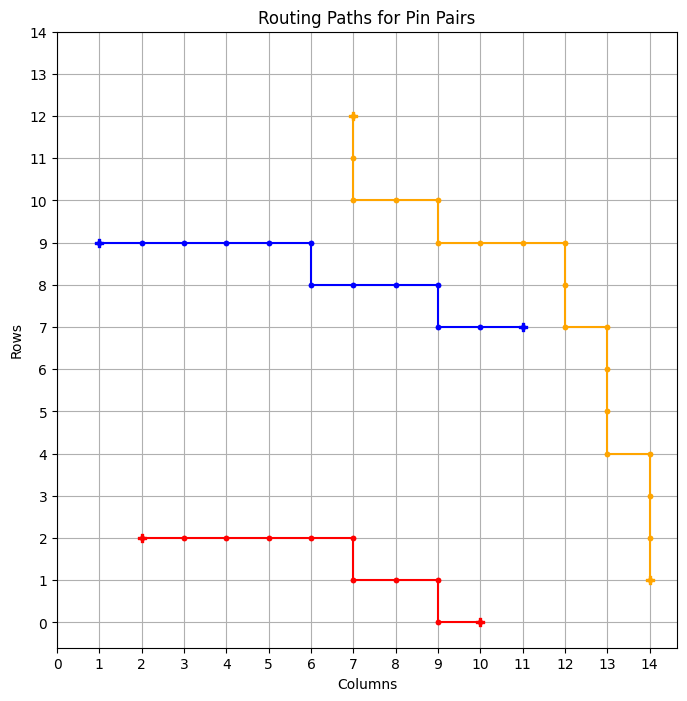

============ BEST GRID ==============
Episode: 1714 	 Total Rewards: tensor([263]) 	 Average Steps: 138.52 	 Elapsed Time: 1003.82
--------------------------------------------------
. . . . . . . . . . . . . . . 
. . . . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * * * . . . 
. . * . . . . . . * * * . . . 
. . * . . . . . * * . . . . . 
. * * . . . . . * . * * S . . 
. * . . . . . . * . * . . . . 
* * * * . . . * * * * . . . . 
* . * * . . . * . * . . . . . 
. . . . . . . * . * . . . . . 
. . . . . . . * * * . . . . . 
. . . . * * * * . . . . . . . 
. D * * * . . . . . . . . . . 
--------------------------------------------------
model_saved : model_best_751
tensor([263])


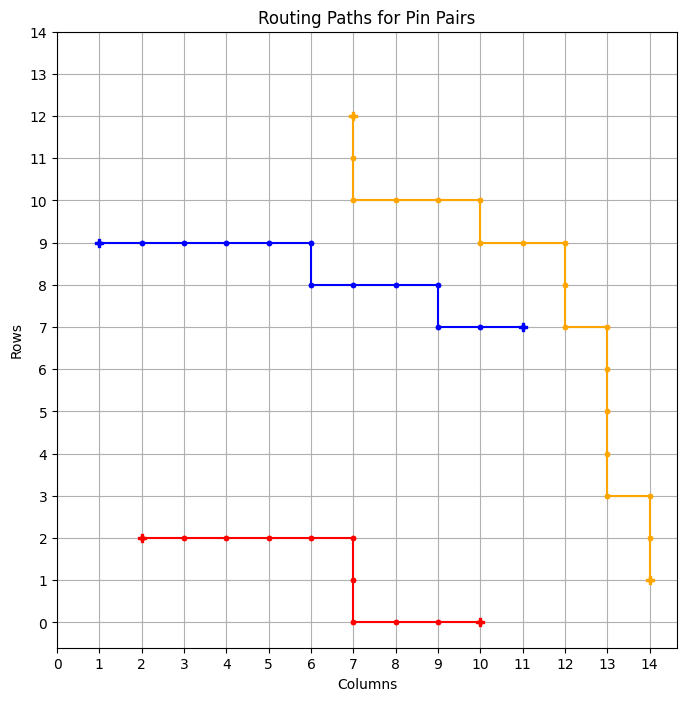

============ BEST GRID ==============
Episode: 1715 	 Total Rewards: tensor([263]) 	 Average Steps: 138.46 	 Elapsed Time: 1004.64
--------------------------------------------------
. . . . . . . . . . . . . . . 
. . . . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * * * . . . 
. . * . . . . . . * * * . . . 
. . * . . . . . * * . . . . . 
* * * . . . . . * . * * S . . 
* . . . . . . . * . * . . . . 
* . * * . . . * * . * . . . . 
* . * * . . . * . * * . . . . 
. . . . . . . * . * . . . . . 
. . . . . . . * * * . . . . . 
. . . * * * * * . . . . . . . 
. D * * . . . . . . . . . . . 
--------------------------------------------------
model_saved : model_best_752
tensor([243])


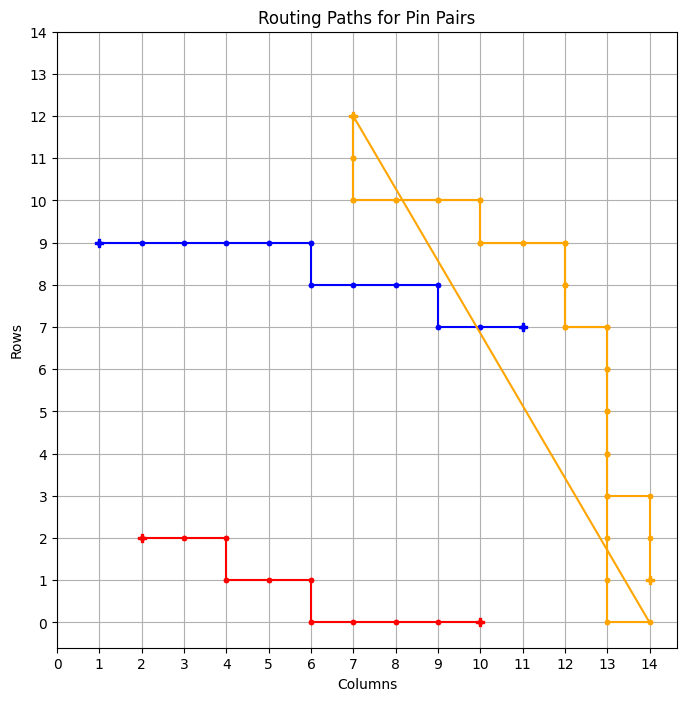

tensor([263])


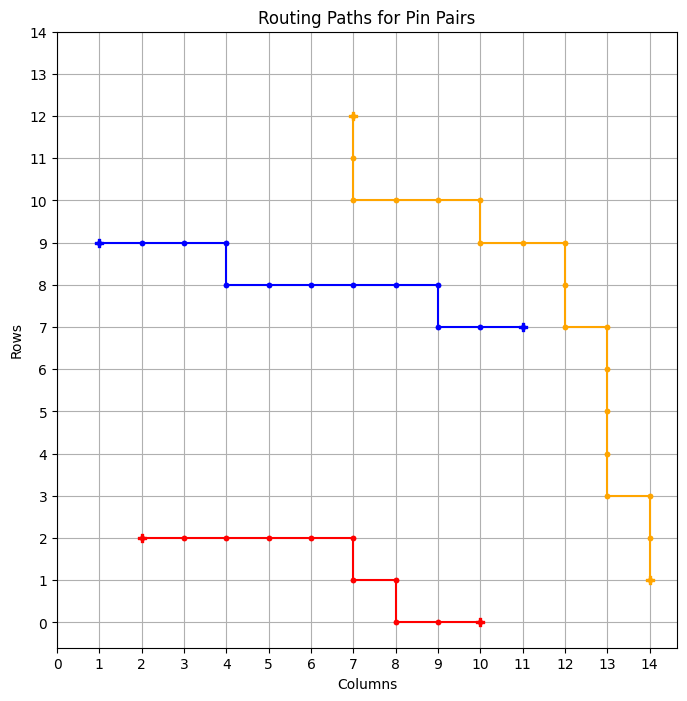

============ BEST GRID ==============
Episode: 1717 	 Total Rewards: tensor([263]) 	 Average Steps: 138.36 	 Elapsed Time: 1006.10
--------------------------------------------------
. . . . . . . . . . . . . . . 
. . . . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . * * * * . . . 
. . * . . . . . * . * * . . . 
. . * . . . . . * . . . . . . 
. * * . . . . . * . * * S . . 
* * . . . . . . * . * . . . . 
* . * * . . . * * . * . . . . 
* . * * . . . * . * * . . . . 
. . . . . . . * . * . . . . . 
. . . . . . . * * * . . . . . 
. . . * * * * * . . . . . . . 
. D * * . . . . . . . . . . . 
--------------------------------------------------
model_saved : model_best_753
tensor([263])


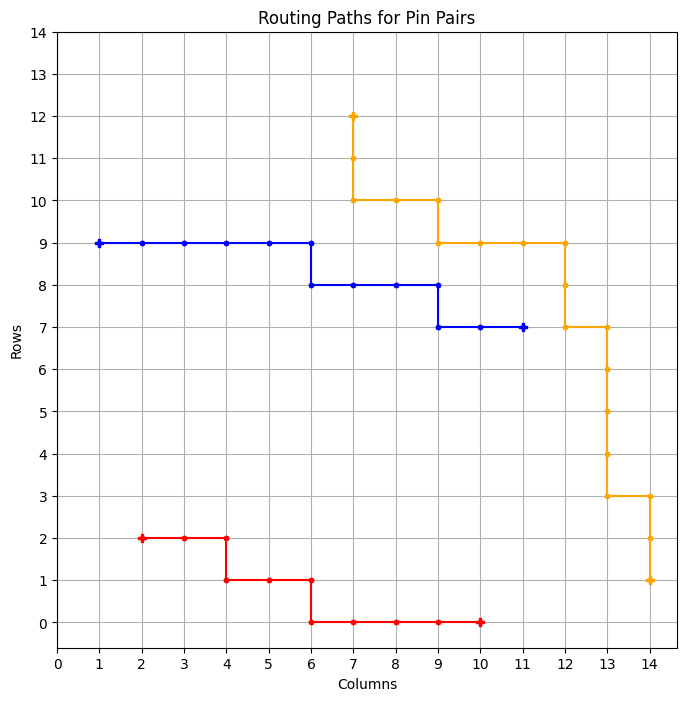

============ BEST GRID ==============
Episode: 1718 	 Total Rewards: tensor([263]) 	 Average Steps: 138.30 	 Elapsed Time: 1006.89
--------------------------------------------------
. . . . . . . . . . . . . . . 
. . . . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. * * . . . . . . * * * . . . 
. * . . . . . . . * * * . . . 
* * . . . . . . * * . . . . . 
* . . . . . . . * . * * S . . 
* . . . . . . . * . * . . . . 
* . * * . . . * * * * . . . . 
* . * * . . . * . * . . . . . 
. . . . . . . * . * . . . . . 
. . . . . . . * * * . . . . . 
. . . * * * * * . . . . . . . 
. D * * . . . . . . . . . . . 
--------------------------------------------------
model_saved : model_best_754
tensor([263])


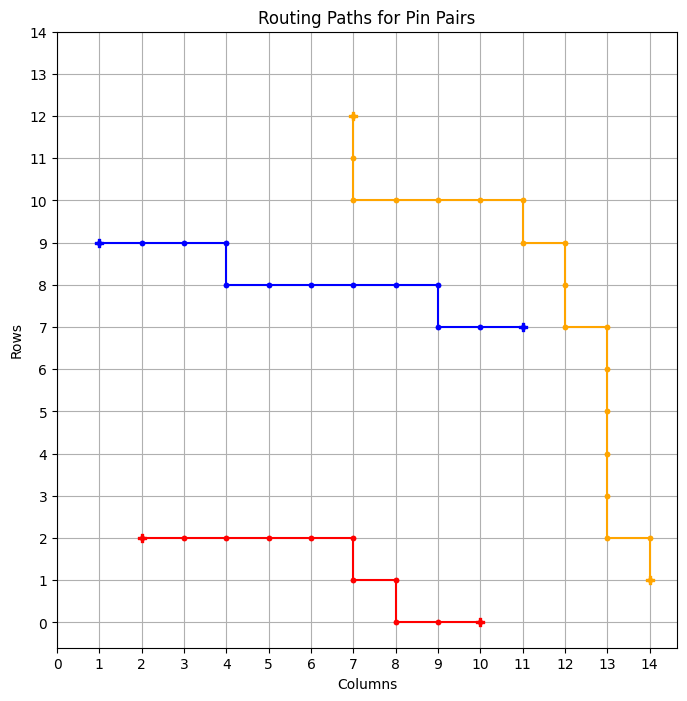

============ BEST GRID ==============
Episode: 1719 	 Total Rewards: tensor([263]) 	 Average Steps: 138.24 	 Elapsed Time: 1008.02
--------------------------------------------------
. . . . . . . . . . . . . . . 
. . . . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . * * * * . . . 
. . * . . . . . * . * * . . . 
. . * . . . . . * . . . . . . 
. * * . . . . . * . * * S . . 
* * . . . . . . * . * . . . . 
* . * * . . . * * . * . . . . 
* . * * . . . * . . * . . . . 
. . . . . . . * . * * . . . . 
. . . . . . . * * * . . . . . 
. . * * * * * * . . . . . . . 
. D * . . . . . . . . . . . . 
--------------------------------------------------
model_saved : model_best_755
tensor([263])


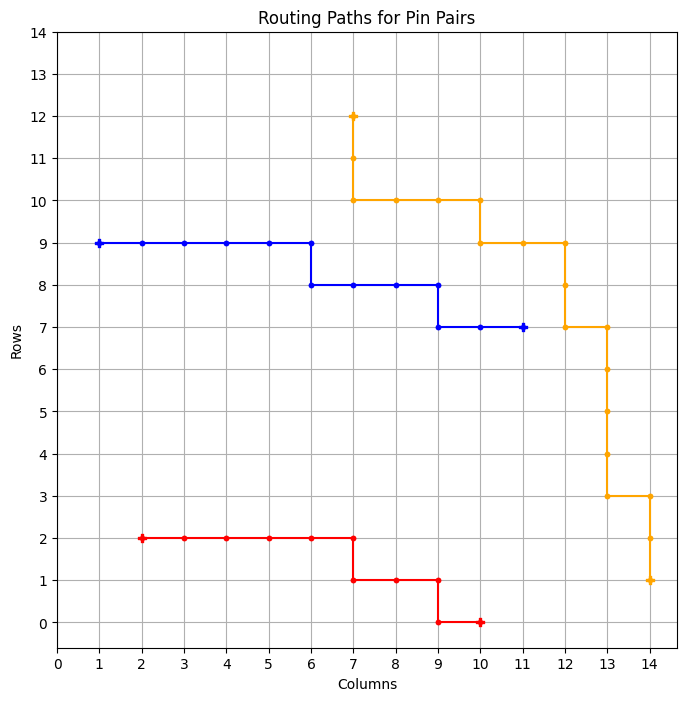

============ BEST GRID ==============
Episode: 1720 	 Total Rewards: tensor([263]) 	 Average Steps: 138.18 	 Elapsed Time: 1008.76
--------------------------------------------------
. . . . . . . . . . . . . . . 
. . . . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * * * . . . 
. . * . . . . . . * * * . . . 
. . * . . . . . * * . . . . . 
. * * . . . . . * . * * S . . 
. * . . . . . . * . * . . . . 
* * * * . . . * * . * . . . . 
* . * * . . . * . * * . . . . 
. . . . . . . * . * . . . . . 
. . . . . . . * * * . . . . . 
. . . * * * * * . . . . . . . 
. D * * . . . . . . . . . . . 
--------------------------------------------------
model_saved : model_best_756
tensor([263])


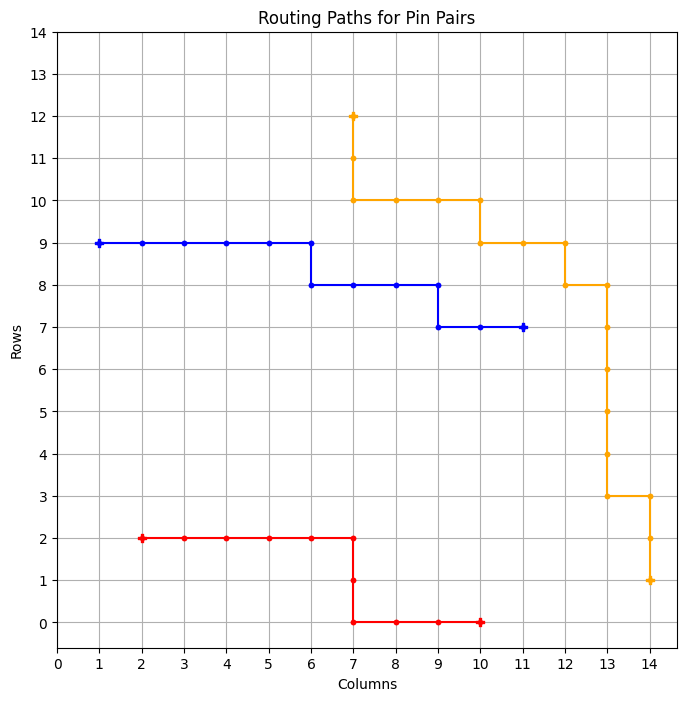

============ BEST GRID ==============
Episode: 1721 	 Total Rewards: tensor([263]) 	 Average Steps: 138.13 	 Elapsed Time: 1009.49
--------------------------------------------------
. . . . . . . . . . . . . . . 
. . . . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * * * . . . 
. . * . . . . . . * * * . . . 
. . * . . . . . * * . . . . . 
* * * . . . . . * . * * S . . 
* . . . . . . . * . * . . . . 
* . * * . . . * * . * . . . . 
* . * * . . . * . * * . . . . 
. . . . . . . * . * . . . . . 
. . . . . . . . * * . . . . . 
. . . * * * * * * . . . . . . 
. D * * . . . . . . . . . . . 
--------------------------------------------------
model_saved : model_best_757
tensor([263])


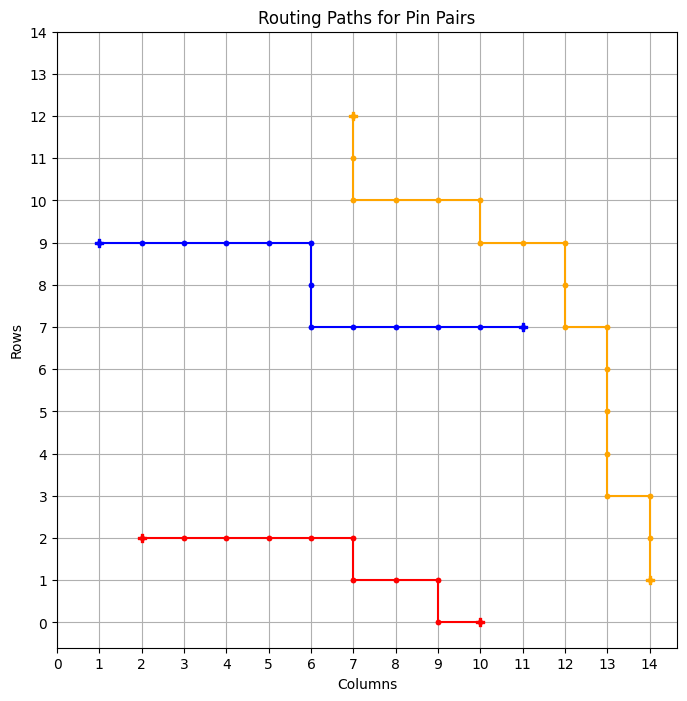

============ BEST GRID ==============
Episode: 1722 	 Total Rewards: tensor([263]) 	 Average Steps: 138.07 	 Elapsed Time: 1010.22
--------------------------------------------------
. . . . . . . . . . . . . . . 
. . . . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * * * . . . 
. . * . . . . . . * * * . . . 
. . * . . . . * * * . . . . . 
. * * . . . . * . . * * S . . 
. * . . . . . * . . * . . . . 
* * * * . . . * . . * . . . . 
* . * * . . . * . * * . . . . 
. . . . . . . * . * . . . . . 
. . . . . . . * * * . . . . . 
. . . * * * * * . . . . . . . 
. D * * . . . . . . . . . . . 
--------------------------------------------------
model_saved : model_best_758
tensor([263])


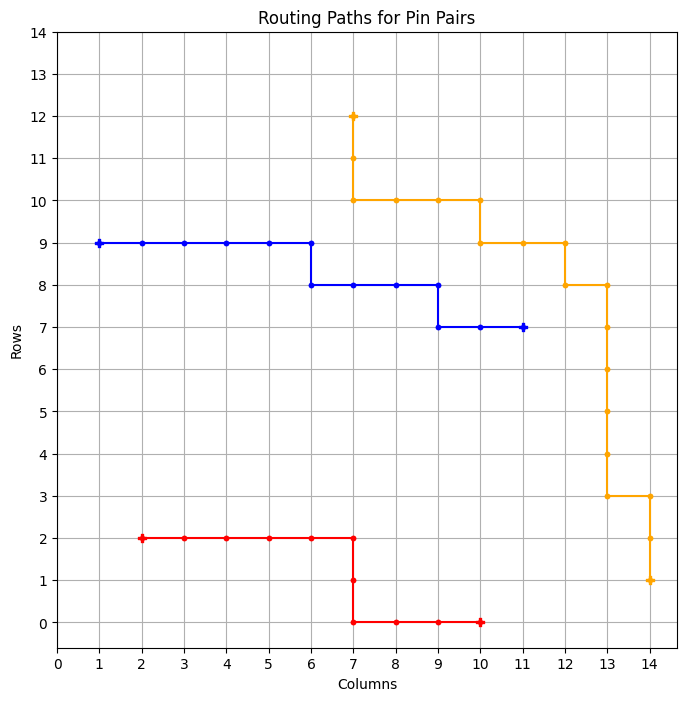

============ BEST GRID ==============
Episode: 1723 	 Total Rewards: tensor([263]) 	 Average Steps: 138.01 	 Elapsed Time: 1011.04
--------------------------------------------------
. . . . . . . . . . . . . . . 
. . . . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * * * . . . 
. . * . . . . . . * * * . . . 
. . * . . . . . * * . . . . . 
* * * . . . . . * . * * S . . 
* . . . . . . . * . * . . . . 
* . * * . . . * * . * . . . . 
* . * * . . . * . * * . . . . 
. . . . . . . * . * . . . . . 
. . . . . . . . * * . . . . . 
. . . * * * * * * . . . . . . 
. D * * . . . . . . . . . . . 
--------------------------------------------------
model_saved : model_best_759
tensor([263])


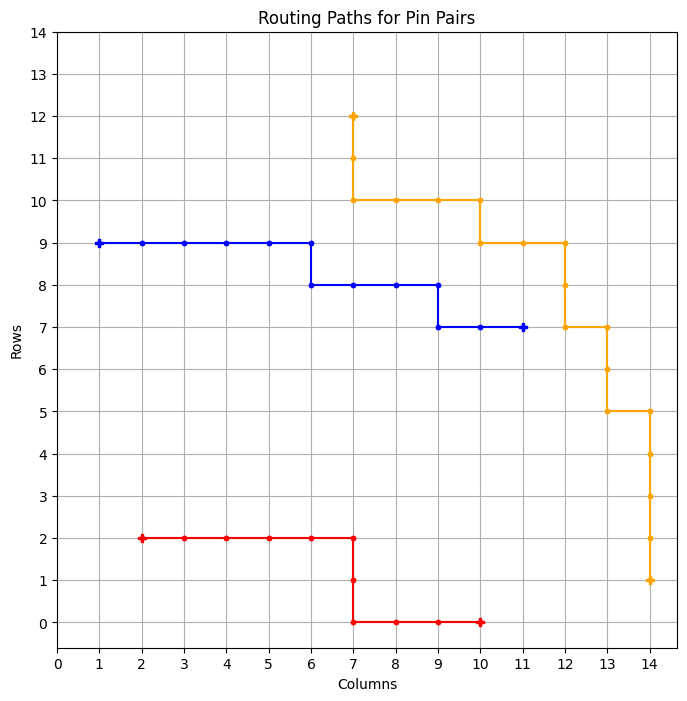

============ BEST GRID ==============
Episode: 1724 	 Total Rewards: tensor([263]) 	 Average Steps: 137.96 	 Elapsed Time: 1011.84
--------------------------------------------------
. . . . . . . . . . . . . . . 
. . . . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * . . . . . 
. . * . . . . . . * * * . . . 
. . * . . . . . . * * * . . . 
. . * . . . . . * * . . . . . 
* * * . . . . . * . * * S . . 
* . . . . . . . * . * . . . . 
* . * * . . . * * . * . . . . 
* . * * . . . * . * * . . . . 
. . . . . . . * . * . . . . . 
. . . . . . . * * * . . . . . 
. . . . . * * * . . . . . . . 
. D * * * * . . . . . . . . . 
--------------------------------------------------
model_saved : model_best_760
tensor([263])


KeyboardInterrupt: ignored

In [39]:
import time
TARGET_UPDATE = 100
num_stepcheck = 200


# def main(pretrain:False, path:str):
def main():

    # Initialize the ActorCritic model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ActorCritic()
    # if pretrain :
    #     model_info = torch.load(path)
    #     model.load_state_dict(model_info['model_state_dict'])
    #     print('load pretrained model!')
    model.to(device)
    print_interval = 20


    # (추가) 에피소드별 평균 단계 수와 총 보상을 기록하는 리스트
    steps_done = 0
    # Wire length 기록
    wire_length = 0
    rewards = []
    avg_steps = []
    solutions = []
    answer = []
    best_reward = -1000000
    best_count = 0

    # Q function 값 저장 list
    avg_q = []
    max_q = []
    # Policy loss 값 저장 list
    avg_pi_loss = []

    start_time = time.time()

    for n_epi in range(10000):

        total_reward = 0
        no_solution = False
        done = False
        env = RoutingEnv(grid, PAIRS[0][0], PAIRS[0][1])
        solutions = []
        s = env.reset(solutions)
        positions = [[],[],[]]
        # Q 값 업데이트 리스트
        q_value = []
        pi_loss = []

        for idx, pair in enumerate(PAIRS):
            solutions.append(env.grid)
            env = RoutingEnv(grid, pair[0], pair[1])
            s = env.reset(solutions)
            #env.render()
            done = False
            step_check = 0



            while not done:
                for t in range(n_rollout):
                    prob = model.pi(s)

                    m = Categorical(prob)
                    a = m.sample().item()
                    s_prime, r, done, position = env.step(a, solutions)
                    model.put_data((s, a, r, s_prime, done))
                    s = s_prime
                    total_reward += r

                    positions[idx].append(position)

                    step_check += 1
                    steps_done += 1

                    # if step_check >= 300:
                    #     # print(f"******* RESET at Step: {step_check} Location: {env.current_position} ******")
                    #     # if env.current_position == (0,6):
                    #     #   print("GOTGOT")
                    #     #   env.render()
                    #     # solutions = []
                    #     state = env.reset(solutions)
                    #     # done = True
                    #     step_check = 0

                    # # env.render()
                    # if (step_done+6000)%6000 == 0:
                    #     env.render()
                    #     print(f'A : {env.current_position}')
                    #     print(f'S : {env.start}')

                    if done:
                        # (추가)
                        # avg_steps.append(steps)
                        # total_rewards.append(total_reward)
                        # print("# of steps :{}, avg score : {:.1f}".format(step_done, total_reward))
                        # if n_epi != 0:
                        #   print("# of episode :{}, pin set number: {}, avg score : {:.1f}".format(n_epi, idx+1, score / print_interval))

                        break
                critic_value, pi_loss_value = model.train_net()
                critic_value = critic_value.detach().cpu().numpy()
                pi_loss_value = pi_loss_value.detach().cpu().numpy()
                q_value.append(critic_value[0])
                pi_loss.append(pi_loss_value)

                if step_check >= num_stepcheck : done = True

            if step_check >= num_stepcheck :
                no_solution = True
                break

        if not no_solution:
            print(total_reward)
            rewards.append(total_reward)
            avg_steps.append(steps_done/(n_epi+1))
            avg_q.append(sum(q_value)/len(q_value))
            max_q.append(max(q_value))
            avg_pi_loss.append(sum(pi_loss)/len(pi_loss))
            q_value= []
            pi_loss = []
            visualize_routing(positions,PAIRS,OBSTACLES)

            if best_reward <= total_reward:
                mid_time = time.time()
                best_reward = total_reward
                best_grid = env.grid
                answer.append(best_grid)
                grid_update = 1
                print("============ BEST GRID ==============")
                print(f"Episode: {n_epi+1} \t Total Rewards: {rewards[-1]} \t Average Steps: {avg_steps[-1] :.2f} \t Elapsed Time: {mid_time - start_time :.2f}")
                env.render()
                best_count += 1
                save_model_info(model, rewards, avg_steps, model_name=f'best_{best_count}')

        if (n_epi+1) % 100 == 0:
          print(f'Episode Done: {n_epi+1} \t Elapsed Time: {time.time() - start_time :.2f}')
          env.render()

        # TARGET_UPDATE번 마다 결과 시각화
        if (n_epi+1) % TARGET_UPDATE == 0:
            plt.figure(figsize=(10, 10))

            plt.subplot(2, 2, 1)
            plt.plot(avg_steps, label='Average Steps per Episode', color='blue')
            plt.xlabel('Episode')
            plt.ylabel('Average Steps')
            plt.title('Episode-wise Steps')

            plt.subplot(2, 2, 2)
            plt.plot(rewards, label='Total Rewards per Episode', color='orange')
            plt.xlabel('Episode')
            plt.ylabel('Total Rewards')
            plt.title('Episode-wise Total Rewards')

            plt.subplot(2, 2, 3)
            plt.plot(avg_pi_loss, label='Average Policy Loss per Episode', color='red')
            plt.xlabel('Episode')
            plt.ylabel('Average Policy Loss')
            plt.title('Episode-wise Policy Loss')

            # plt.subplot(2, 2, 3)
            # plt.plot(avg_q, label='Average Q value per Episode', color='red')
            # plt.xlabel('Episode')
            # plt.ylabel('Average Q value')
            # plt.title('Episode-wise Average Q value')

            plt.subplot(2, 2, 4)
            plt.plot(max_q, label='Max Q value per Episode', color='green')
            plt.xlabel('Episode')
            plt.ylabel('Max Q value')
            plt.title('Episode-wise Max Q value')

            plt.tight_layout()
            plt.show()


# if __name__ == '__main__':
#     pretrain = False
#     path = './models/model_update.pth'
#     main(pretrain, path)

if __name__ == '__main__':
  main()